In [31]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az

Pull in data.

In [2]:
data = pd.read_csv('diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


We see that if we look at the distribution of the BloodPressure column (after dropping 0), that the data looks to be relatively Normally distributed.

In [13]:
bp = data['BloodPressure']
bp = bp[bp != 0]

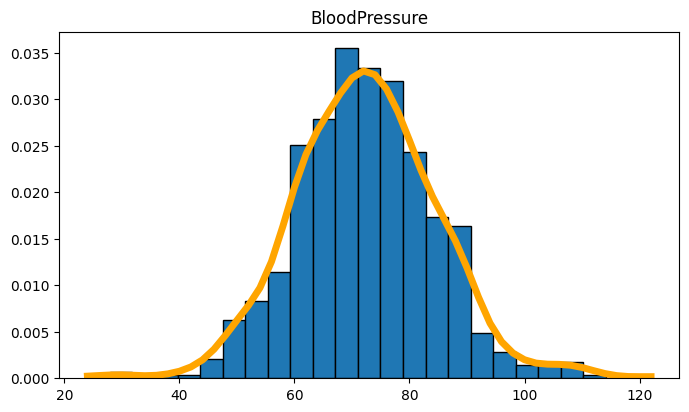

In [14]:
plt.figure(figsize=[8,4.5])
x = ss.gaussian_kde(bp)
lin = np.linspace(bp.min(), bp.max(), 50)
plt.hist(bp, bins=25, edgecolor='black', density=True)
plt.plot(lin, x(lin), color='orange', linewidth=5)
plt.title('BloodPressure')
plt.show()

### Bayesian Inference

We are going to use the pymc package to perform a Markov Chain Monte Carlo to use Bayesian inference on the BloodPressure variable. Say, for example, that our dataset only sampled a small sample of the Pima Indian population. When looking at the blood pressure of samples of our dataset, we can see that our mean reading is 72.41. If we wanted 

In [16]:
bp.mean(), bp.std()

(72.40518417462484, 12.38215821010526)

In [21]:
with pm.Model():
    mu = pm.Normal('mu', mu=72.41, sigma=100)
    sigma = pm.Lognormal('sigma', mu=12.38, sigma=10)
    pmbp = pm.Normal('bp', mu=mu, sigma=sigma, observed=np.array(bp))
    step = pm.Metropolis()
    trace = pm.sample(draws=15000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [sigma]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
Sampling 4 chains for 1_000 tune and 15_000 draw iterations (4_000 + 60_000 draws total) took 3 seconds.


In [32]:
stacked = az.extract(trace)

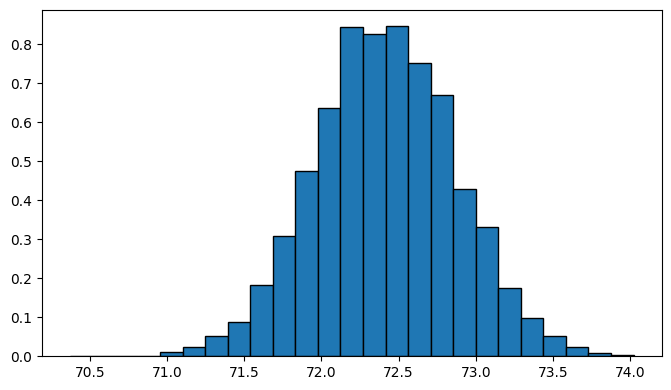

In [39]:
plt.figure(figsize=[8,4.5])
plt.hist(stacked.mu.values, edgecolor='black', density=True, bins=25)
plt.show()

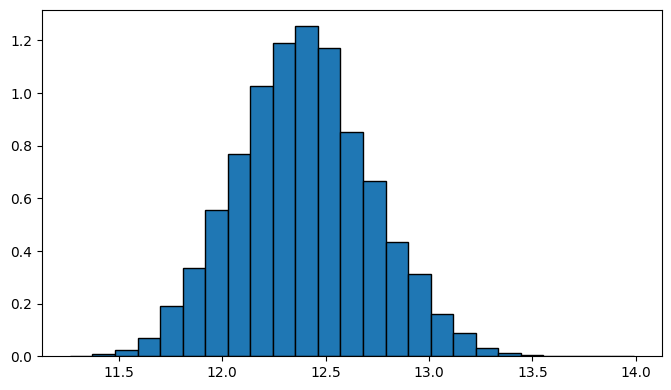

In [40]:
plt.figure(figsize=[8,4.5])
plt.hist(stacked.sigma.values, edgecolor='black', density=True, bins=25)
plt.show()